In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import functools
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import norm
from statsmodels.regression.linear_model import OLS
from scipy.stats import pearsonr

import warnings
warnings.filterwarnings("ignore")
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics 
import sklearn
pd.set_option('use_inf_as_na', True)
from collections import Counter

import optuna
from optuna.trial import Trial
optuna.logging.set_verbosity(optuna.logging.FATAL)

import lightgbm as lgb
import optuna.integration.lightgbm as gbm
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

from lightgbm import LGBMRegressor
from lightgbm import early_stopping
from lightgbm import log_evaluation

from functools import partial
import pickle as pkl
from pathlib import Path
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
from sktime.performance_metrics.forecasting import mean_absolute_error
from sktime.performance_metrics.forecasting import mean_squared_error
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error

In [114]:
def model_evaluate(y_test, y_pred, var):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = MeanAbsolutePercentageError(symmetric=False)
    mape = mape(y_test, y_pred)
    smape = MeanAbsolutePercentageError()
    smape_val = smape(y_test, y_pred)
#     mase = mean_absolute_scaled_error(y_test, y_pred, y_train = y_train)
    return pd.DataFrame([[mae,mse,rmse,mape,smape_val]],columns = ['MAE','MSE','RMSE','MAPE','sMAPE'],index= ['Test vs Pred - ' + var])

In [3]:
data_gbp = pd.read_csv('GBP.csv',index_col=0)
data_cad = pd.read_csv('CAD.csv',index_col=0)
data_eur = pd.read_csv('EUR.csv',index_col=0)
data_nzd = pd.read_csv('NZD.csv',index_col=0)
data_jpy = pd.read_csv('JPY.csv',index_col=0)
data_gbp.index = pd.to_datetime(data_gbp.index)
data_cad.index = pd.to_datetime(data_cad.index)
data_eur.index= pd.to_datetime(data_eur.index)
data_nzd.index = pd.to_datetime(data_nzd.index)
data_jpy.index= pd.to_datetime(data_jpy.index)

In [28]:
def objective_smape_gbm(trial:Trial,train_x,train_y,test_x,test_y, extra=None):

    min_child_samples = trial.suggest_int('min_child_samples', 5, 100)
    num_leaves = trial.suggest_int('num_leaves', 2, 256)
    learning_rate = trial.suggest_uniform('learning_rate', 0.05, .7)
    n_estimators = trial.suggest_int('n_estimators', 2, 100)

    clf = LGBMRegressor(num_leaves=num_leaves,
                        objective = 'mape',
                        learning_rate=learning_rate,
                        n_estimators=n_estimators,
                        min_child_samples=min_child_samples,
                        n_jobs=-1
                       )
    
    clf.fit(train_x, train_y)
    y_pred = clf.predict(test_x, num_iteration=clf.best_iteration_)
    mape = MeanAbsolutePercentageError(symmetric=False)
    return mape(test_y, y_pred)

## GBP LGBM Regressor

In [117]:
data_gbp['GBPUSD_Shift']= data_gbp['GBPUSD'].shift()
X_gbp, y_gbp = data_gbp[['YC/GBR5Y - Yield','YC/USA5Y - Rate','GBPUSD_Shift']],data_gbp['GBPUSD']
data_gbp

,GBPUSD,YC/GBR5Y - Yield,YC/USA5Y - Rate,Change in Spot,Direction,GBPUSD_Shift
Date,,,,,,
2004-08-23,0.55120,4.9500,3.42,0.00210,1,NaN
2004-08-24,0.55760,5.0300,3.46,0.00640,1,0.55120
2004-08-25,0.55660,5.0300,3.46,-0.00100,0,0.55760
2004-08-26,0.55740,4.9800,3.46,0.00080,1,0.55660
2004-08-27,0.55800,4.9600,3.42,0.00060,1,0.55740
...,...,...,...,...,...,...
2019-12-25,0.77035,0.5506,1.72,-0.00155,0,0.77190
2019-12-26,0.76880,0.5510,1.72,-0.00155,0,0.77035
2019-12-27,0.76390,0.5514,1.72,-0.00490,0,0.76880


In [96]:
classifiers = []
pred = []
smape_XG = []

modeldf = data_gbp.copy()
opt_features = ['YC/GBR5Y - Yield','YC/USA5Y - Rate','GBPUSD_Shift']
y = ['GBPUSD']

h = 180
start_dates = modeldf.index[:-h]
end_dates = modeldf.index[500:]

training_frames = [modeldf.loc[start_dates[i]:start_dates[i+499]] for i in range(0,len(start_dates)-499,90+1)]
validation_frames = [modeldf.loc[end_dates[i]:end_dates[i+89]] for i in range(0,len(end_dates)-h,90+1)]
test_frames = [modeldf.loc[end_dates[i+90]:end_dates[i+180]] for i in range(0,len(end_dates)-h,90+1)]

training_data = [d[opt_features] for d in training_frames]
validation_data = [d[opt_features] for d in validation_frames]
test_data = [d[opt_features] for d in test_frames]

training_labels = [d[y].values for d in training_frames]
validation_labels = [d[y].values for d in validation_frames]
test_labels = [d[y].values for d in test_frames]

for i in range(len(training_labels)):
        
    study = optuna.create_study(direction='minimize')
    study.optimize(partial(objective_smape_gbm,train_x=training_data[i],
                               train_y=training_labels[i],
                               test_x=validation_data[i],
                               test_y=validation_labels[i]),
                               n_trials=100,n_jobs=-1)
        
    gbm_clf = LGBMRegressor(**study.best_params)
    classifiers.append(gbm_clf)
    classifiers[i].fit(training_data[i],training_labels[i])

    #predicted signal
    pred_test = classifiers[i].predict(test_data[i])
    pred.extend(pred_test)
    smape = MeanAbsolutePercentageError()
    smape_i = smape(test_labels[i],pred_test)
    smape_XG.append(smape_i)
    print(smape_i)

0.020602064634368682
0.03375068599824329
0.031468661258990165
0.009914437075735846
0.0045616187751428075
0.12683273017449673
0.24366920790868662
0.02353430201803991
0.0128059210014269
0.009351330812462349
0.008696228397635812
0.005095397382480983
0.004444798115773058
0.004879134495370319
0.004171065366776176
0.003631907186788234
0.003735989660860432
0.0072865532142098585
0.01269399832895991
0.004816705962513482
0.017960704917303446
0.04184752724155935
0.0034664386891851864
0.007772651956276849
0.004588618525860873
0.004649789176235016
0.0354985207560768
0.08443567871596701
0.11333321964521134
0.06136297214549256
0.005475310487649986
0.006935579799487127
0.006222038015105243
0.0035205112995847407
0.005326621716059849
0.0042366568048352446
0.01463820778082534


In [97]:
np.mean(smape_XG)

0.02695172393085615

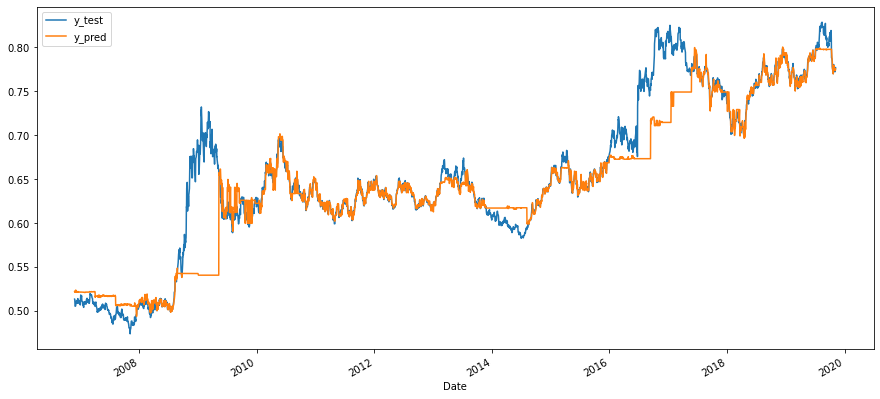

In [112]:
y_test= data_gbp[y].loc['2006-11-28':'2019-11-05']
y_test.plot(figsize = (15,7))
y_pred= pd.Series(pred,index =data_gbp[y].loc['2006-11-28':'2019-11-05'].index)
y_pred.plot()
plt.legend(['y_test','y_pred'])
plt.show()

In [116]:
gbp_summary = model_evaluate(y_test, y_pred, 'GBPUSD')

## EUR LGBM Regressor

In [118]:
data_eur = pd.read_csv('EUR.csv',index_col=0)
data_eur.index = pd.to_datetime(data_eur.index)
data_eur['EURUSD_Shift']= data_eur['EURUSD'].shift()
data_eur

,EURUSD,YC/FRA5Y - Rate,YC/USA5Y - Rate,Change in Spot,Direction,EURUSD_Shift
Date,,,,,,
2004-08-23,0.81990,0.594002,3.42,0.00850,1,NaN
2004-08-24,0.82650,0.594020,3.46,0.00660,1,0.81990
2004-08-25,0.82710,0.594037,3.46,0.00060,1,0.82650
2004-08-26,0.82750,0.594055,3.46,0.00040,1,0.82710
2004-08-27,0.83160,0.594072,3.42,0.00410,1,0.82750
...,...,...,...,...,...,...
2019-12-25,0.90145,-0.351000,1.72,-0.00075,0,0.90220
2019-12-26,0.90070,-0.354667,1.72,-0.00075,0,0.90145
2019-12-27,0.89490,-0.358333,1.72,-0.00580,0,0.90070


In [119]:
classifiers = []
pred = []
smape_XG_EUR = []

modeldf = data_eur.copy()
opt_features = ['YC/FRA5Y - Rate', 'YC/USA5Y - Rate','EURUSD_Shift']
y = ['EURUSD']

h = 180
start_dates = modeldf.index[:-h]
end_dates = modeldf.index[500:]

training_frames = [modeldf.loc[start_dates[i]:start_dates[i+499]] for i in range(0,len(start_dates)-499,90+1)]
validation_frames = [modeldf.loc[end_dates[i]:end_dates[i+89]] for i in range(0,len(end_dates)-h,90+1)]
test_frames = [modeldf.loc[end_dates[i+90]:end_dates[i+180]] for i in range(0,len(end_dates)-h,90+1)]

training_data = [d[opt_features] for d in training_frames]
validation_data = [d[opt_features] for d in validation_frames]
test_data = [d[opt_features] for d in test_frames]

training_labels = [d[y].values for d in training_frames]
validation_labels = [d[y].values for d in validation_frames]
test_labels = [d[y].values for d in test_frames]

for i in range(len(training_labels)):
        
    study = optuna.create_study(direction='minimize')
    study.optimize(partial(objective_smape_gbm,train_x=training_data[i],
                               train_y=training_labels[i],
                               test_x=validation_data[i],
                               test_y=validation_labels[i]),
                               n_trials=100,n_jobs=-1)
        
    gbm_clf = LGBMRegressor(**study.best_params)
    classifiers.append(gbm_clf)
    classifiers[i].fit(training_data[i],training_labels[i])

    #predicted signal
    pred_test = classifiers[i].predict(test_data[i])
    pred.extend(pred_test)
    smape = MeanAbsolutePercentageError()
    smape_i = smape(test_labels[i],pred_test)
    smape_XG_EUR.append(smape_i)
    print(smape_i)

0.00588596522418069
0.01898484002921512
0.06157784038903857
0.0918729600716984
0.05021407921773744
0.1083399894361501
0.038921725589207146
0.010410465961824851
0.005351821605230875
0.010395234771690109
0.017302141673591637
0.007567028857322673
0.0056814239363632444
0.006925933865430045
0.006478737064808228
0.006598319064431723
0.005857422462348397
0.007105851979220544
0.00434018528104753
0.00603220633405979
0.006333426911236113
0.004643723038264027
0.0034411111546496878
0.12485939263023461
0.1146901554211461
0.01626081064950297
0.005852533137117845
0.003823313755610236
0.010194594440102938
0.0047495593701148385
0.026925679226437852
0.05100685053377299
0.0306271910359983
0.00870508270181664
0.004016380440820282
0.010711440370785004
0.005336889215743269


In [120]:
np.mean(smape_XG_EUR)

0.024541143428322997

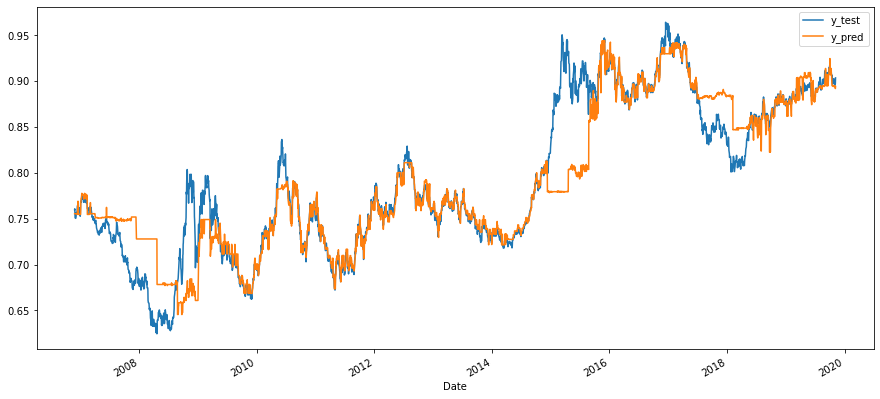

In [123]:
y_test= data_eur[y].loc['2006-11-28':'2019-11-05']
y_test.plot(figsize = (15,7))
y_pred= pd.Series(pred,index =data_eur[y].loc['2006-11-28':'2019-11-05'].index)
y_pred.plot()
plt.legend(['y_test','y_pred'])
plt.show()

In [124]:
eur_summary = model_evaluate(y_test, y_pred, 'EURUSD')

## CAD LGBM Regressor

In [150]:
data_cad = pd.read_csv('CAD.csv',index_col=0)
data_cad.index = pd.to_datetime(data_cad.index)
data_cad['CADUSD_Shift']= data_cad['CADUSD'].shift()

In [151]:
classifiers = []
pred = []
smape_XG_CAD = []

modeldf = data_cad.copy()
opt_features = ['YC/CAN5Y - Rate', 'YC/USA5Y - Rate','CADUSD_Shift']
y = ['CADUSD']

h = 180
start_dates = modeldf.index[:-h]
end_dates = modeldf.index[500:]

training_frames = [modeldf.loc[start_dates[i]:start_dates[i+499]] for i in range(0,len(start_dates)-499,90+1)]
validation_frames = [modeldf.loc[end_dates[i]:end_dates[i+89]] for i in range(0,len(end_dates)-h,90+1)]
test_frames = [modeldf.loc[end_dates[i+90]:end_dates[i+180]] for i in range(0,len(end_dates)-h,90+1)]

training_data = [d[opt_features] for d in training_frames]
validation_data = [d[opt_features] for d in validation_frames]
test_data = [d[opt_features] for d in test_frames]

training_labels = [d[y].values for d in training_frames]
validation_labels = [d[y].values for d in validation_frames]
test_labels = [d[y].values for d in test_frames]

for i in range(len(training_labels)):
        
    study = optuna.create_study(direction='minimize')
    study.optimize(partial(objective_smape_gbm,train_x=training_data[i],
                               train_y=training_labels[i],
                               test_x=validation_data[i],
                               test_y=validation_labels[i]),
                               n_trials=100,n_jobs=-1)
        
    gbm_clf = LGBMRegressor(**study.best_params)
    classifiers.append(gbm_clf)
    classifiers[i].fit(training_data[i],training_labels[i])

    #predicted signal
    pred_test = classifiers[i].predict(test_data[i])
    pred.extend(pred_test)
    smape = MeanAbsolutePercentageError()
    smape_i = smape(test_labels[i],pred_test)
    smape_XG_CAD.append(smape_i)
    print(smape_i)

0.0031455388545864084
0.02932507397458613
0.09910070053546202
0.047003441444092166
0.005411508215765616
0.033040775802453
0.049081429163935215
0.011388948556831084
0.00842054094079101
0.00807249208376833
0.005897988126830079
0.00961287988468777
0.04664249302049859
0.01628528819576287
0.004376976640056754
0.004489210440295121
0.003479078164554512
0.003178968503594292
0.007665192018195709
0.0063895358941375175
0.03934015090650403
0.031340983617794575
0.006932186253090919
0.09123322685939725
0.09043727444057414
0.04774608279153345
0.03306741409281222
0.00697754307710068
0.011445083891284664
0.003990055456812811
0.0037952222518788776
0.007362962506617028
0.0037749680975489148
0.0034280571202331706
0.0055972872925905874
0.003554674776668193
0.002568540121440601


In [152]:
np.mean(smape_XG_CAD)

0.02147566956796666

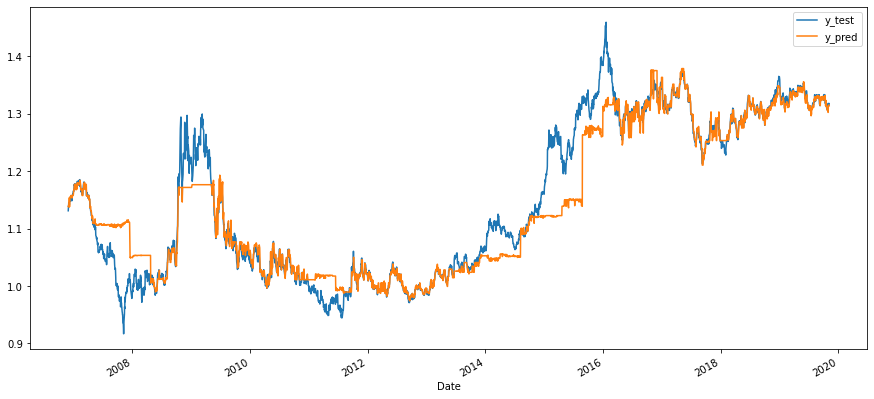

In [153]:
y_test= data_cad[y].loc['2006-11-28':'2019-11-05']
y_test.plot(figsize = (15,7))
y_pred= pd.Series(pred,index =data_cad[y].loc['2006-11-28':'2019-11-05'].index)
y_pred.plot()
plt.legend(['y_test','y_pred'])
plt.show()

In [154]:
cad_summary = model_evaluate(y_test, y_pred, 'CADUSD')

## NZD LGBM Regressor

In [136]:
data_nzd = pd.read_csv('NZD.csv',index_col=0)
data_nzd.index = pd.to_datetime(data_nzd.index)
data_nzd['NZDUSD_Shift']= data_nzd['NZDUSD'].shift()

In [131]:
classifiers = []
pred = []
smape_XG_NZD = []

modeldf = data_nzd.copy()
opt_features = ['YC/NZL5Y - Rate', 'YC/USA5Y - Rate','NZDUSD_Shift']
y = ['NZDUSD']

h = 180
start_dates = modeldf.index[:-h]
end_dates = modeldf.index[500:]

training_frames = [modeldf.loc[start_dates[i]:start_dates[i+499]] for i in range(0,len(start_dates)-499,90+1)]
validation_frames = [modeldf.loc[end_dates[i]:end_dates[i+89]] for i in range(0,len(end_dates)-h,90+1)]
test_frames = [modeldf.loc[end_dates[i+90]:end_dates[i+180]] for i in range(0,len(end_dates)-h,90+1)]

training_data = [d[opt_features] for d in training_frames]
validation_data = [d[opt_features] for d in validation_frames]
test_data = [d[opt_features] for d in test_frames]

training_labels = [d[y].values for d in training_frames]
validation_labels = [d[y].values for d in validation_frames]
test_labels = [d[y].values for d in test_frames]

for i in range(len(training_labels)):
        
    study = optuna.create_study(direction='minimize')
    study.optimize(partial(objective_smape_gbm,train_x=training_data[i],
                               train_y=training_labels[i],
                               test_x=validation_data[i],
                               test_y=validation_labels[i]),
                               n_trials=100,n_jobs=-1)
        
    gbm_clf = LGBMRegressor(**study.best_params)
    classifiers.append(gbm_clf)
    classifiers[i].fit(training_data[i],training_labels[i])

    #predicted signal
    pred_test = classifiers[i].predict(test_data[i])
    pred.extend(pred_test)
    smape = MeanAbsolutePercentageError()
    smape_i = smape(test_labels[i],pred_test)
    smape_XG_NZD.append(smape_i)
    print(smape_i)

0.006476561918267279
0.041899009388116346
0.038311965789435166
0.02830357867978529
0.00987771226375856
0.0628000385974084
0.1929685413435884
0.018857033792923802
0.037474466465851446
0.009249895404769505
0.00815877834777838
0.022537802695050284
0.04026716636603242
0.05186370275884083
0.012873348937243458
0.006377506428048088
0.007576639834380143
0.005589284172483956
0.007193282091144721
0.008065732303789867
0.0065624694916860205
0.021672452638964133
0.007045251569180037
0.03400553239486905
0.10200903832327873
0.11681534656024972
0.017646867760728498
0.012843950296097636
0.0077344462600965344
0.006034845703477253
0.005336556499418743
0.005793697082172384
0.004601062804830711
0.01763840783074102
0.020495676052779875
0.0064934397117226835
0.024018715968090007


In [132]:
np.mean(smape_XG_NZD)

0.021900500840372778

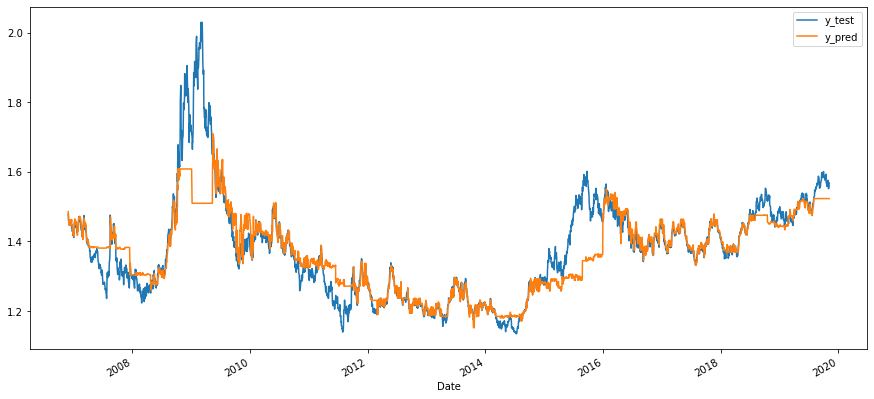

In [134]:
y_test= data_nzd[y].loc['2006-11-28':'2019-11-05']
y_test.plot(figsize = (15,7))
y_pred= pd.Series(pred,index =data_nzd[y].loc['2006-11-28':'2019-11-05'].index)
y_pred.plot()
plt.legend(['y_test','y_pred'])
plt.show()

In [137]:
nzd_summary = model_evaluate(y_test, y_pred, 'NZDUSD')

## NZD LGBM Regressor

In [139]:
data_jpy = pd.read_csv('JPY.csv',index_col=0)
data_jpy.index = pd.to_datetime(data_jpy.index)
data_jpy['JPYUSD_Shift']= data_jpy['JPYUSD'].shift()

In [140]:
classifiers = []
pred = []
smape_XG_JPY = []

modeldf = data_jpy.copy()
opt_features = ['YC/JPN5Y - Yield', 'YC/USA5Y - Rate','JPYUSD_Shift']
y = ['JPYUSD']

h = 180
start_dates = modeldf.index[:-h]
end_dates = modeldf.index[500:]

training_frames = [modeldf.loc[start_dates[i]:start_dates[i+499]] for i in range(0,len(start_dates)-499,90+1)]
validation_frames = [modeldf.loc[end_dates[i]:end_dates[i+89]] for i in range(0,len(end_dates)-h,90+1)]
test_frames = [modeldf.loc[end_dates[i+90]:end_dates[i+180]] for i in range(0,len(end_dates)-h,90+1)]

training_data = [d[opt_features] for d in training_frames]
validation_data = [d[opt_features] for d in validation_frames]
test_data = [d[opt_features] for d in test_frames]

training_labels = [d[y].values for d in training_frames]
validation_labels = [d[y].values for d in validation_frames]
test_labels = [d[y].values for d in test_frames]

for i in range(len(training_labels)):
        
    study = optuna.create_study(direction='minimize')
    study.optimize(partial(objective_smape_gbm,train_x=training_data[i],
                               train_y=training_labels[i],
                               test_x=validation_data[i],
                               test_y=validation_labels[i]),
                               n_trials=100,n_jobs=-1)
        
    gbm_clf = LGBMRegressor(**study.best_params)
    classifiers.append(gbm_clf)
    classifiers[i].fit(training_data[i],training_labels[i])

    #predicted signal
    pred_test = classifiers[i].predict(test_data[i])
    pred.extend(pred_test)
    smape = MeanAbsolutePercentageError()
    smape_i = smape(test_labels[i],pred_test)
    smape_XG_JPY.append(smape_i)
    print(smape_i)

0.00749841806470077
0.015744161681443013
0.00559674997609616
0.05128225266368816
0.029756682956379996
0.04301451804694571
0.03885065577808358
0.02328731594223053
0.00998150104727441
0.006455926878707787
0.02815702021953338
0.05872974832891642
0.04892644498322372
0.05190640152415262
0.04067018294479811
0.00622812509002099
0.003923372829393149
0.05427882557444126
0.16839549331072312
0.036004126784832335
0.024084843847464073
0.017182938832610885
0.06047792604707692
0.12932535084957067
0.026608341965159134
0.007900480489089293
0.011949970274267748
0.011730955628193318
0.006449209829329892
0.009411129578678968
0.00855698412621511
0.003979320982026333
0.005150152234660425
0.0034690777077768
0.0028318735509570325
0.003649238949735403
0.004683376948890848


In [141]:
np.mean(smape_XG_JPY)

0.028814299904521293

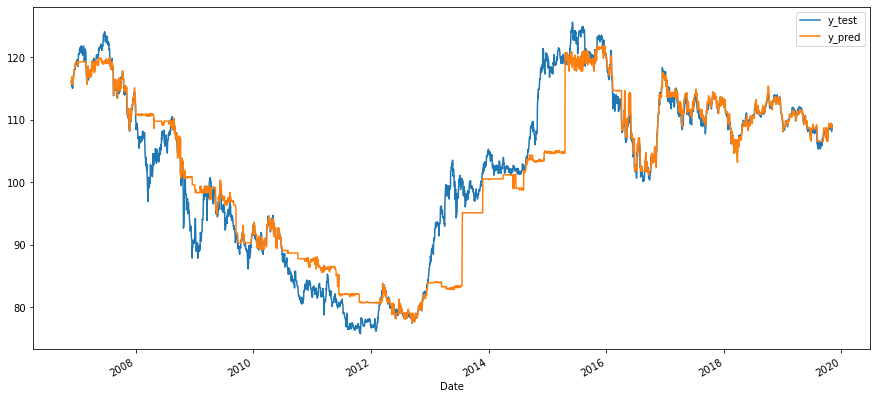

In [143]:
y_test= data_jpy[y].loc['2006-11-28':'2019-11-05']
y_test.plot(figsize = (15,7))
y_pred= pd.Series(pred,index =data_jpy[y].loc['2006-11-28':'2019-11-05'].index)
y_pred.plot()
plt.legend(['y_test','y_pred'])
plt.show()

In [142]:
jpy_summary = model_evaluate(y_test, y_pred, 'JPYUSD')

In [155]:
pd.concat([eur_summary, nzd_summary, gbp_summary,cad_summary,jpy_summary], axis = 0).to_csv('Rollingstat.csv')

In [156]:
pd.concat([eur_summary, nzd_summary, gbp_summary,cad_summary,jpy_summary], axis = 0)

,MAE,MSE,RMSE,MAPE,sMAPE
Test vs Pred - EURUSD,0.019175,0.001206,0.034734,0.024268,0.024541
Test vs Pred - NZDUSD,0.040428,0.006223,0.078886,0.027181,0.027932
Test vs Pred - GBPUSD,0.017487,0.001349,0.036730,0.025662,0.026952
Test vs Pred - CADUSD,0.024521,0.001809,0.042528,0.021332,0.021476
Test vs Pred - JPYUSD,0.040428,0.006223,0.078886,0.027181,0.027932
